In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import torch
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.utils import shuffle
from torch.utils.data import random_split
from PIL import Image
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# target_directory = '/kaggle/input/nzmsa-2024/cifar10_images/train/'

# files_and_dirs = os.listdir(target_directory)

# for item in files_and_dirs:
#    print(item)

# read train csv
csv_file = '/kaggle/input/nzmsa-2024/train.csv'
labels_df = pd.read_csv(csv_file)

print(labels_df.head())
print(labels_df.info())


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   id  label
0   0      7
1   1      8
2   2      8
3   3      2
4   4      9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      50000 non-null  int64
 1   label   50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB
None


Before I begin, I would like to say that I am very sorry that I was not able to successfully train the required model in the specified time. When developing with kaggle's notebook, training the model with a training set of 50,000 images was extremely time-consuming. And any mistake in the middle of the training may lead to failure. So I chose to settle for the next best thing, using Subset that samples half of the original data as a training set. Although this will affect the performance of the model, "first solve whether there is, then solve the good and bad". I will try to train the full data set in subsequent development, and if successful, I will show it in the code and comments.

This deep learning model is trained using PyTorch framework. At the same time, the processing part of the image is referred to the task guidance in the third part.This deep learning model is trained using PyTorch framework. At the same time, the processing part of the image is referred to the task guidance in the third part. The first thing we need to do is import and separate the data. However, since torch's default ImageDataset function requires the file's subfolder to be the data's label. The tags for our test set are stored in a csv file. Therefore, we need to first define a function to convert the data and add the tag corresponding to the ID.

In [2]:
# Define a function to load and transform the dataset
class MyImageDataset(Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
    
        self.image_dir = image_dir
        self.transform = transform
        
        # Transfer the label df to dictionary
        self.labels = labels_df.set_index('id')['label'].to_dict()
        
        # Get the name of all the images
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  
        img_id = self.image_files[idx].split('_')[1].split('.')[0]  
        label = self.labels.get(int(img_id), -1)  
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, img_id


The next step is to turn the images into data sets.

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Set the path of the image set
image_dir_train = '/kaggle/input/nzmsa-2024/cifar10_images/train/'

# Load and transform the dataset
dataset = MyImageDataset(image_dir=image_dir_train, labels_df=labels_df, transform=transform)

As mentioned earlier, I decided to reduce the training time by sampling first to test the feasibility of the model (the current sampling ratio is 0.5).

The data is separated at the end of sampling. Since there are pictures specially used for testing in this model training, we divided the original data set into the training set and the verification set, and the segmentation ratio was 8:2.

Finally we use data loaders for loading and processing data sets.

In [4]:
# Shuffle and sample indices
total_size = len(dataset)
indices = list(range(total_size))
sampled_indices = shuffle(indices, random_state=42)[:int(total_size * 0.3)]  # Sample 30% of the indices

# Create a subset of the dataset
sampled_dataset = Subset(dataset, sampled_indices)

# Define the split ratio
train_ratio = 0.8
val_ratio = 0.2

# Recalculate dataset splits
total_size = len(sampled_dataset)
train_size = int(total_size * train_ratio)
val_size = total_size - train_size

# Split dataset
train_dataset, val_dataset = random_split(sampled_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

The following code is used to verify the results of running the ImageDataset. See if the labels and ids in the generated dataset correspond by changing the numbers in [].

In [5]:
image, label, img_id_1 = sampled_dataset[2]

# Print the sampled info to check the ID and the Label
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"ID: {img_id_1}")

Image shape: torch.Size([3, 256, 256])
Label: 2
ID: 12307


This section is the definition part of the model. This part mainly includes: the initialization of model structure, the definition of forward propagation logic and the definition of some built-in functions.

When initializing the model structure, I defined the input size, hidden layer size, and output size, while also wrapping weights and bigots with torch.nn.Parameter to facilitate optimization and gradient calculations with PyTorch. In the forward propagation logic, I define the input, bias and weighting, activation and output for each layer step by step. Finally, there are some commonly used built-in functions, such as linear computation.

At the end of this cell, I initialized the model

In [6]:
#Define the model
class MyMLPModel(torch.nn.Module):
    def __init__(self):
        super(MyMLPModel, self).__init__()
        
        # Define sizes for layers
        self.input_size = 256 * 256 * 3
        self.hidden_size1 = 512
        self.hidden_size2 = 256
        self.output_size = 10
        
        # Initialize weights and biases 
        self.fc1_weights = torch.nn.Parameter(torch.randn(self.input_size, self.hidden_size1) * 0.01)
        self.fc1_bias = torch.nn.Parameter(torch.zeros(self.hidden_size1))
        
        self.fc2_weights = torch.nn.Parameter(torch.randn(self.hidden_size1, self.hidden_size2) * 0.01)
        self.fc2_bias = torch.nn.Parameter(torch.zeros(self.hidden_size2))
        
        self.fc3_weights = torch.nn.Parameter(torch.randn(self.hidden_size2, self.output_size) * 0.01)
        self.fc3_bias = torch.nn.Parameter(torch.zeros(self.output_size))

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)
        
        # Apply the first fully connected layer
        x = self.linear(x, self.fc1_weights, self.fc1_bias)
        x = self.relu(x)
        
        # Apply the second fully connected layer
        x = self.linear(x, self.fc2_weights, self.fc2_bias)
        x = self.relu(x)
        
        # Apply the third fully connected layer (output layer)
        x = self.linear(x, self.fc3_weights, self.fc3_bias)
        
        return x

    def linear(self, x, weights, bias):
        return torch.matmul(x, weights) + bias

    def relu(self, x):
        return x * (x > 0).float()

# Instantiate the model
model = MyMLPModel()


The purpose of function is to calculate the cross-entropy loss, a loss function commonly used in classification problems. The calculation steps of the loss function include: converting the logits of the model output into logarithmic probabilities, selecting the probability of the real label from the logarithmic probabilities, calculating the negative sum of these probabilities, and averaging the batch size to get the final loss value.

In [7]:
# Define a simple cross-entropy loss function
def cross_entropy_loss(outputs, labels):
    log_probs = torch.log_softmax(outputs, dim=1)
    loss = -torch.sum(log_probs[range(labels.size(0)), labels]) / labels.size(0)
    return loss

# Instantiate the loss function
criterion = cross_entropy_loss

The SGDOptimizer class is a manually implemented random gradient descent optimizer. Its features include:
The model parameters and learning rate are passed in, the gradient is cleared before each optimization step, and the model parameters are updated according to the calculated gradient and learning rate.

In [8]:
# Define a SGD optimizer
class SGDOptimizer:
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

# Instantiate Optimizer
optimizer = SGDOptimizer(model.parameters(), lr=0.001)

The following code is a complete model training and validation process. It includes MLP training, model validation and output results at each iteration. This last one is used to monitor the training process during model training.

In [9]:
# Define the training of the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for this epoch
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        
        epoch_duration = time.time() - start_time  # Calculate time taken for this epoch
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Time: {epoch_duration:.2f}s')
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
        

Then comes the long process of training the model.

In [10]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=8)

Epoch 1/8, Loss: 2.1934, Accuracy: 0.1893, Time: 493.58s
Validation Loss: 2.0599, Validation Accuracy: 0.2520
Epoch 2/8, Loss: 2.0253, Accuracy: 0.2666, Time: 503.78s
Validation Loss: 1.9597, Validation Accuracy: 0.2863
Epoch 3/8, Loss: 1.9418, Accuracy: 0.3051, Time: 501.54s
Validation Loss: 1.8912, Validation Accuracy: 0.3300
Epoch 4/8, Loss: 1.8843, Accuracy: 0.3272, Time: 494.00s
Validation Loss: 1.8526, Validation Accuracy: 0.3467
Epoch 5/8, Loss: 1.8358, Accuracy: 0.3423, Time: 487.12s
Validation Loss: 1.8110, Validation Accuracy: 0.3573
Epoch 6/8, Loss: 1.7977, Accuracy: 0.3560, Time: 482.74s
Validation Loss: 1.7814, Validation Accuracy: 0.3763
Epoch 7/8, Loss: 1.7676, Accuracy: 0.3702, Time: 489.45s
Validation Loss: 1.7782, Validation Accuracy: 0.3497
Epoch 8/8, Loss: 1.7341, Accuracy: 0.3820, Time: 482.07s
Validation Loss: 1.7861, Validation Accuracy: 0.3507


The accuracy of the model in the training set and the validation set is shown in the output information above

Here are the cells that will convert the images from the test set

In [11]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# define the dataset
class CustomTestDataset(Dataset):
    def __init__(self, image_folder_path, transform=None):
        self.image_folder_path = image_folder_path
        self.image_filenames = [f for f in os.listdir(image_folder_path) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder_path, self.image_filenames[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_filenames[idx]

# define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 确保图像大小与模型输入大小一致
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# create dataset and data loader
test_dataset = CustomTestDataset('/kaggle/input/nzmsa-2024/cifar10_images/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Below is the prediction and generate a csv that records the predicted values.

In [12]:
import torch
import pandas as pd

# Predict and save the result
def predict_and_save(model, test_loader, output_file):
    all_predictions = []
    
    with torch.no_grad():
        for images, filenames in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for filename, label in zip(filenames, predicted):
                file_id = os.path.splitext(filename)[0].replace('image_', '')
                all_predictions.append((file_id, label.item()))
    
    # create the dataframe and store in the csv
    df = pd.DataFrame(all_predictions, columns=['id', 'label'])
    df.to_csv(output_file, index=False)

# Predict!
predict_and_save(model, test_loader, 'test_predictions.csv')


The following is the function used to generate the metrics needed to evaluate the model

In [17]:
import torch

def get_predictions_and_labels(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, _ in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

predictions, true_labels = get_predictions_and_labels(model, val_loader)


The following is the generation and visualization of the confusion matrix

Confusion Matrix:
 [[ 25  16  45  23  74  60   3  44  12   9]
 [  4  91  68  14  63  13   4  27   9  10]
 [  1  15 124  10  88   7  11  47   3   1]
 [  3   5  12 187  35   9  11   2  20  17]
 [  4   8  44  24 142  11  10  33   4   9]
 [ 15   8  30  18  74  94   1  46   5   1]
 [  1   7  21 100  96   6  46   7   6   6]
 [  6   7  48   9  70  22   1 122   3   4]
 [  6  21   5  64  17   5  14  30 116  37]
 [  6  12  10  53  25   6   9  28  40 105]]


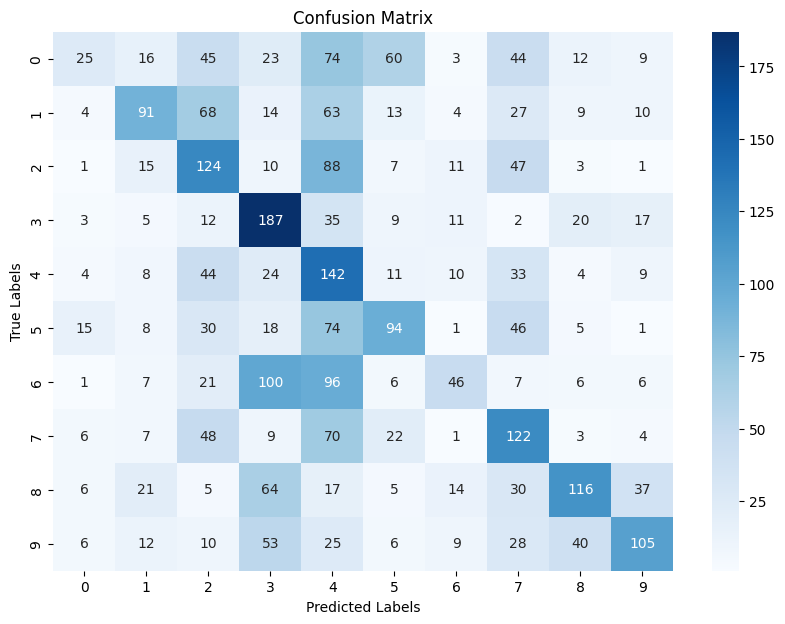

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)

print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Here are some other model metrics

In [22]:
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')


Precision: 0.3923
Recall: 0.3507
F1 Score: 0.3409
Accuracy: 0.3507


Overall, the resulting model is far from ideal due to the sampling of the metadata set to reduce training time. But as the monitoring information printed when training the model shows, this process really takes too much time. If we use a more powerful calculator, or adopt a less complex algorithm, we may be able to effectively shorten the training time.

All in all, this notebook presents a deep learning training process for the PyTorch structure. From image transformation, data set segmentation to model definition, loss function and optimizer definition, and finally model training and evaluation. Although the results of the final model were not satisfactory, I still benefited a lot from the process. In particular, the deep learning model is developed with structured thinking, so that the development process of the model is clear and the goal is clear.

Finally, thank you very much for taking the time to review my work, and have fun with your predictions!